# Example Optimization on 8x1 Split-Ring Structure in BCC

In [1]:
import os, sys
import torch
import mlflow
import numpy as np
import matplotlib.pyplot as plt

from DiffSimPyPipeline import CalculationPipeline as pipeline
import NetworkFunctions
from OptimizationFunctions import create_folders
from typing import Callable

from cosimpy import S_Matrix, EM_Field

## General Initialization

In [2]:
path = "./data/8x1/bcc_8x1_export"

In [3]:
freq = 123.5 #MHz
numPorts = 10

em_field_no_mts = EM_Field.importFields_cst("./data/8x1/bcc_8x1_export_nomts/Field", 
                                        freqs=[freq], 
                                        nPorts=1, 
                                        Pinc_ref=1,
                                        b_multCoeff=1,
                                        pkORrms='rms',
                                        fileType = 'ascii', 
                                        col_ascii_order = 1)

s_matrix = S_Matrix.importTouchstone(os.path.join(path, f"s_param.s{numPorts}p"))
em_field = EM_Field.importFields_cst(os.path.join(path, "Field"), 
                                        freqs=[freq], 
                                        nPorts=numPorts, 
                                        Pinc_ref=1, 
                                        b_multCoeff=1,
                                        pkORrms='rms',
                                        fileType = 'ascii', 
                                        col_ascii_order = 1)

s_matrix_unconnected = torch.from_numpy(s_matrix.S).to(torch.cdouble)
b_field_import = torch.tensor(em_field.b_field/em_field_no_mts.b_field, dtype=torch.cdouble) #Signal Enhancement instead of absolute field

# For Optimization: Only interested in field in centre of each cell at 123.5MHz
b_field_import_for_optimization = b_field_import[:,:,:,::64]
freq_id = np.where(s_matrix.frequencies == freq*10**6)[0][0]

Importing 123.5 MHz fields

	Importing port1 fields



Importing 123.5 MHz fields

	Importing port10 fields




S_Matrix.py: Line 30 - WARNING - The S matrix seems to be unphysical at least at one frequency value. Healing the S matrix with the healSMatrix method could solve the problem


## Initialization of DiffSimPy Pipeline

In [4]:
#Create Tuning Networks for BCC
C_tune = 17.8e-12
R_tune = 40
tuning_networks = S_Matrix.sMatrixPInetwork(None, None, S_Matrix.sMatrixRCseries(R_tune, C_tune, freqs=[123.5e6], z0=50))
tuning_networks = tuning_networks.S.squeeze()

In [5]:
n0=numPorts
n1=2
nf=1
batch_size=1

S_C_const = torch.zeros((batch_size, nf, n0+n1, n0+n1), dtype=torch.cdouble)
S_C_const[:, :, -2, 0] = tuning_networks[0, 1]
S_C_const[:, :, 0, -2] = tuning_networks[0, 1]
S_C_const[:, :, -1, 1] = 1j*tuning_networks[0, 1]
S_C_const[:, :, 1, -1] = 1j*tuning_networks[0, 1]

S_C_const[:, :, 0, 0] = tuning_networks[0, 0]
S_C_const[:, :, 1, 1] = 1j*tuning_networks[0, 0]
S_C_const[:, :, -1, -1] = tuning_networks[0, 0]
S_C_const[:, :, -2, -2] = 1j*tuning_networks[0, 0]
# Transmission from excitation port to all other ports

In [6]:
id_x = [x+n1 for x in range(numPorts-n1)]
indices = torch.tensor([id_x, id_x]) #define indices for S_C

In [7]:
calc_pipe = pipeline(S_0 = s_matrix_unconnected[freq_id], # as we are only interested in 123.5MHz, we can neglect other frequencies
                     S_C_const = S_C_const,
                     b_field = b_field_import_for_optimization,
                     e_field = None)

In [8]:
omega = 2*torch.pi*freq*10**6

In [9]:
num_epochs = 2000
learning_rate = 1e-13
experiment_name = "GD_8x1_BCC_Demo"

# Desired B Field generation

In [10]:
def process_BCC_fields(field):
    return torch.abs(field[:,0,0,1,:] + field[:,0,1,1,:]) # combine field components of both excitation ports with phaseshift of 90°

In [11]:
def custom_preprocessing(Rvalue, Cvalue, omega):
    z = NetworkFunctions.calc_RC_series_impedance(Rvalue, Cvalue, omega)
    s = NetworkFunctions.z_to_s(z, 50)
    s = s.unsqueeze(1) #add dimension for nf
    return s

In [12]:
Y_0 = S_Matrix.getYMatrix(s_matrix)
y = torch.from_numpy(Y_0[freq_id, n1:, n1:]) #drops excitation coil
c_init = NetworkFunctions.extract_initial_params(omega, y)

In [13]:
c_init = c_init.unsqueeze(0)

In [14]:
custom_preprocessing(torch.ones_like(c_init), c_init, omega).shape

torch.Size([1, 1, 8])

In [15]:
max_value = torch.mean(process_BCC_fields(calc_pipe(custom_preprocessing(torch.ones_like(c_init), c_init, omega), indices)[0]))
min_value = 1

In [16]:
print("Max Value: ", max_value, "Min Value: ", min_value)

Max Value:  tensor(2.1818) Min Value:  1


In [17]:
# systematic pattern generation
from scipy.linalg import hadamard
n_col_points = 8
peaks = torch.diag(torch.ones((n_col_points)))
troughs = torch.bitwise_not(peaks.bool()).int()
hadamard_pattern = torch.tensor((hadamard(n_col_points) + 1) / 2)
gradient_array = np.linspace(0, 1, n_col_points)
homogenization_pattern = torch.ones((n_col_points,n_col_points))*gradient_array[:, np.newaxis]

In [18]:
# arbitrary pattern
torch.manual_seed(42)
arbitrary_patterns = torch.rand((1000, 8))

In [19]:
desired_h = torch.vstack((peaks,troughs, hadamard_pattern, homogenization_pattern, arbitrary_patterns))

In [20]:
desired_h = desired_h*(max_value - min_value) + min_value

# Optimization

In [21]:
eval_loss_obj = torch.nn.MSELoss()

In [23]:
mlflow.set_tracking_uri('./mlruns')
mlflow.set_experiment(experiment_name)

2024/12/10 12:36:11 INFO mlflow.tracking.fluent: Experiment with name 'GD_8x1_BCC_Demo' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspace/diffsimpy/example/mlruns/655444258904507576', creation_time=1733834171096, experiment_id='655444258904507576', last_update_time=1733834171096, lifecycle_stage='active', name='GD_8x1_BCC_Demo', tags={}>

In [24]:
create_folders(f"./output/{experiment_name}")
initial_params = c_init.repeat(len(desired_h), 1).detach().requires_grad_(True)
optimizer = torch.optim.Adam([initial_params], lr=learning_rate)
mlflow.start_run()

# Optimization procedure
prev_best_eval_loss = 1
best_params = initial_params
best_params_epoch = 0
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Clear gradients

    s_opt = custom_preprocessing(torch.ones_like(initial_params), initial_params, omega)
    output = calc_pipe(s_opt, indices)  # Forward pass
    opt_field = process_BCC_fields(output[0]) #specific to this example

    loss = eval_loss_obj(opt_field, desired_h)  # Compute loss
    loss.backward()  # Backward pass to compute gradients
    optimizer.step()  # Update parameters
    
    eval_loss = loss.item()
    print(f"epoch: {epoch}, loss: {eval_loss}")
    if eval_loss<=prev_best_eval_loss:
        if epoch - best_params_epoch > 3:
            print(f"best_eval_loss: {eval_loss} @ epoch {epoch}")
        best_params = initial_params.detach()
        best_params_epoch = epoch
        best_params_output = opt_field.detach()
        prev_best_eval_loss = eval_loss
        
    if epoch == 0:
        opt_field_init = opt_field    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
    mlflow.log_metric("MSE", loss.item(), step=epoch)
    
mlflow.log_metric("best_params_epoch", best_params_epoch)
mlflow.log_metric("best_eval_loss", prev_best_eval_loss)
torch.save(best_params, f"./output/{experiment_name}/best_params.pt")
torch.save(best_params_output, f"./output/{experiment_name}/best_params_output.pt")
torch.save(desired_h, f"./output/{experiment_name}/desired_field.pt")
#mlflow.log_artifact("/workspace")
#mlflow.log_artifact("/packages")
mlflow.end_run()

Directory "./output/GD_8x1_BCC_Demo" created
epoch: 0, loss: 0.46797761906715696
Epoch 0, Loss: 0.46797761906715696
epoch: 1, loss: 0.3363661959136853
epoch: 2, loss: 0.22099973101169604
epoch: 3, loss: 0.14003763427188454
epoch: 4, loss: 0.09766566796792761
epoch: 5, loss: 0.08335052484621361
epoch: 6, loss: 0.0825053717027
epoch: 7, loss: 0.08475870806679406
epoch: 8, loss: 0.08528037680333642
epoch: 9, loss: 0.08293692600240267
epoch: 10, loss: 0.07827668405521591
best_eval_loss: 0.07827668405521591 @ epoch 10
epoch: 11, loss: 0.07230721651373918
epoch: 12, loss: 0.0658938097348343
epoch: 13, loss: 0.0595794518179902
epoch: 14, loss: 0.05367946613106837
epoch: 15, loss: 0.04839948554733619
epoch: 16, loss: 0.0438504499904625
epoch: 17, loss: 0.04003141207219953
epoch: 18, loss: 0.03684285307117456
epoch: 19, loss: 0.034125977244181586
epoch: 20, loss: 0.031707769793443606
epoch: 21, loss: 0.02944606757668633
epoch: 22, loss: 0.027263481975346632
epoch: 23, loss: 0.02515226067528998


# Evaluation

In [25]:
calc_pipe_full_resolution = pipeline(S_0 = s_matrix_unconnected[freq_id], # as we are only interested in 123.5MHz, we can neglect other frequencies
                     S_C_const = S_C_const,
                     b_field = b_field_import,
                     e_field = None)

In [26]:
full_output = process_BCC_fields(calc_pipe_full_resolution(custom_preprocessing(torch.ones_like(initial_params), best_params, omega), indices)[0])

In [27]:
def extract_indices_of_quartiles(metric_list: np.ndarray) -> dict:
    return {
        "Min": np.argsort(metric_list)[0],
        "Q1": np.argsort(metric_list)[len(metric_list)//4],
        "Q2": np.argsort(metric_list)[len(metric_list)//2],
        "Q3": np.argsort(metric_list)[int(len(metric_list)*(3/4))],
        "Max": np.argsort(metric_list)[-1]
     }


In [28]:
eval_mse = torch.nn.MSELoss(reduction='none')
mse_list = torch.mean(eval_mse(best_params_output, desired_h), axis=1)

In [29]:
indices_of_quartiles = extract_indices_of_quartiles(mse_list.tolist())

In [30]:
plt.rcParams.update({
    "figure.figsize": (3.5, 3.5),
    "font.size": 8 
})
x_range = np.arange(0, 449, 64)
x_pos = np.linspace(-105, 105, 449)

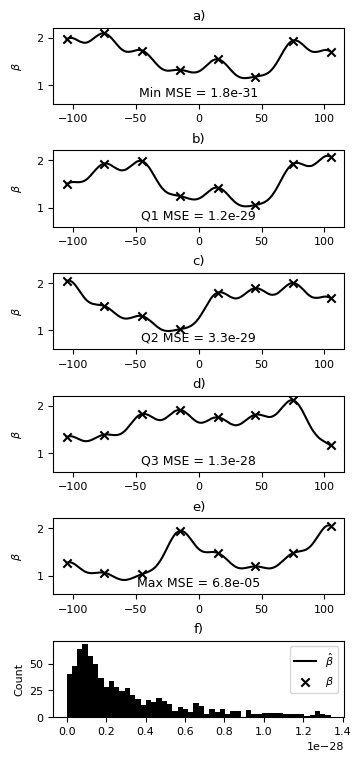

In [31]:
fig, axs = plt.subplots(6, 1, constrained_layout=True)
axs = axs.reshape((6, 1))
fig.set_size_inches(3.5, 7.5)
#fig.suptitle(f"Distribution Plots")

field = full_output.detach().numpy()

plt.align_labels = True
#plt.suptitle(f"Model_id: {1}")
for count, key in enumerate(indices_of_quartiles.keys()):
    col_ind=0
    row_ind=count

    #line_test = axs[row_ind, col_ind].plot(x_range, torch.abs(output_list[indices_of_quartiles[index]])[freq_id][0][-1].numpy())
    line_test = axs[row_ind, col_ind].plot(x_pos, field[indices_of_quartiles[key]], linestyle='-', color='black', label=r"$\hat{\beta}$")
    line_pred = axs[row_ind, col_ind].scatter(x_pos[::64], desired_h[indices_of_quartiles[key]], color='black', marker='x', label=r"$\beta$")
    axs[row_ind, col_ind].set_ylim(0.6, np.max(field))
    additional_letters = ["a)", "b)", "c)", "d)", "e)", "f)"]
    axs[row_ind, col_ind].set_ylabel(r"$\beta$")
    axs[row_ind, col_ind].set_title(f"{additional_letters[count]}")
    axs[row_ind, col_ind].text(
        0.5, 0.15,  # x, y coordinates in figure fraction
        f"{key} MSE = {mse_list[indices_of_quartiles[key]]:.1e}", 
        horizontalalignment='center',
        verticalalignment='center',
        transform=axs[row_ind, col_ind].transAxes,
        fontsize=9
    )     

# Extract handles and labels from the first subplot
#line_test[0].set_label('$|H_z|\*$')
#line_pred[0].set_label('$|H_z|^'$')
handles, labels = axs[0, 0].get_legend_handles_labels()

row_ind = count+1
axs[row_ind, col_ind].hist(mse_list.detach().numpy(), bins=50, range = [0, np.percentile(mse_list.detach().numpy(), 75)], color='black')
axs[row_ind, col_ind].set_ylabel("Count")
axs[row_ind, col_ind].set_title(f"{additional_letters[-1]}")

axs[row_ind, col_ind].legend(handles, labels, loc='best')
fig.align_ylabels()
plt.savefig(f"./output/{experiment_name}/mse_distribution_plot.pdf")
plt.savefig(f"./output/{experiment_name}/mse_distribution_plot.png")

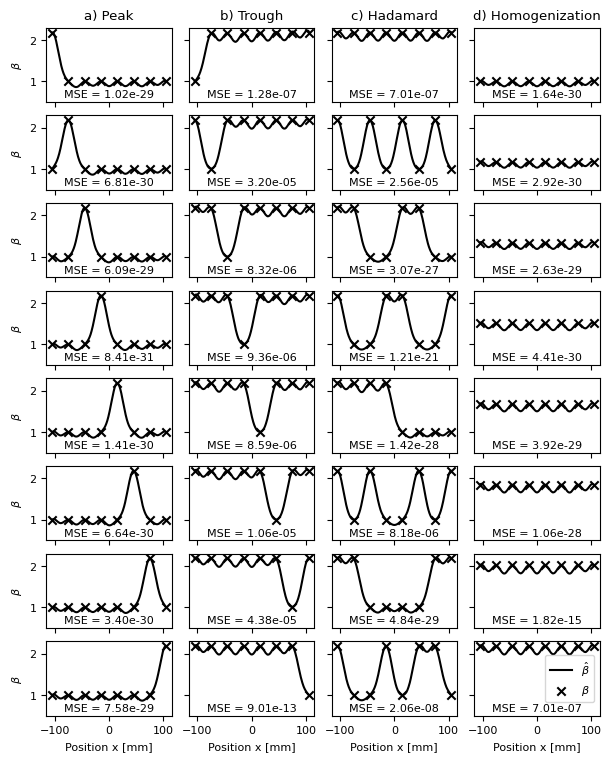

In [ ]:
# Systematic pattern evaluation
col_ind = -1
fig, axs = plt.subplots(8, 4, constrained_layout=True, sharex=True, sharey=True)
fig.set_size_inches(6, 7.5)#8.27*0.7, 11.6*0.7)

titles = ["a) Peak", "b) Trough", "c) Hadamard", "d) Homogenization"]

error_list = []
for idx in range(32):
    row_ind = idx%8
    if idx%8 == 0:
        col_ind += 1
        axs[row_ind, col_ind].set_title(titles[col_ind])
    
    field = full_output[idx]
    # Adding text to each subplot
    error = eval_loss_obj(field[::64], desired_h[idx,:])
    error_list.append(error.item())
    text_label = f"MSE = {mse_list[idx]:.2e}"
    axs[row_ind, col_ind].text(0.5, 0.1, text_label, ha='center', va='center', transform=axs[row_ind, col_ind].transAxes)
    axs[row_ind, col_ind].plot(x_pos, field.detach().numpy(), color='black', label=r"$\hat{\beta}$")
    axs[row_ind, col_ind].scatter(x_pos[::64], desired_h[idx,:], marker='x', color='black', label=r"$\beta$")
    
    #handles, labels = axs[0, 0].get_legend_handles_labels()
    if col_ind == 0:
        axs[row_ind, col_ind].set_ylabel(r"$\beta$")
    if row_ind == 7:
        axs[row_ind, col_ind].set_xlabel("Position x [mm]")
    axs[row_ind, col_ind].set_ylim(0.5, 2.3)

axs[-1, -1].legend()

plt.savefig(f"./output/{experiment_name}/8x1_systematic_pattern_demo.png")
plt.savefig(f"./output/{experiment_name}/8x1_systematic_pattern_demo.pdf")   